<img src="https://raw.githubusercontent.com/maverick-faus/Files/master/DeepDeamon2.png" alt="drawing" width="100px"/>
# Red 4B - Puesta en marcha
TT: Deep Deep Dishes  
Food recommendation System  
ESCOM  
By Faus - 2K18


In [0]:
import tensorflow as tf
import numpy as np
import pickle 
from sklearn.metrics import confusion_matrix
from PIL import Image,ImageOps 
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
!pip install PyDrive
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fileIdLabelmap = '1WFD03892EOtRIfEYKOAJRilqiEGzzDTX'
#label map
downloaded1 = drive.CreateFile({'id': fileIdLabelmap})
downloaded1.GetContentFile("4B3.ckpt.data-00000-of-00001")

fileIdLabelmap = '1vJMT8uw1aXL0p62wzOpEuCCZp6P_HsNQ'
#label map
downloaded1 = drive.CreateFile({'id': fileIdLabelmap})
downloaded1.GetContentFile("4B3.ckpt.index")

fileIdLabelmap = '1c7JNawj9Tygm4c6eNC2mkgzAJmjTbm5d'
#label map
downloaded1 = drive.CreateFile({'id': fileIdLabelmap})
downloaded1.GetContentFile("4B3.ckpt.meta")


In [6]:
!ls

4B3.ckpt.data-00000-of-00001  4B3.ckpt.meta   adc.json	drive
4B3.ckpt.index		      4B_test.pickle  CNNClass	sample_data


In [0]:
def deep_neural_convolutional_class(
    batch_size=20,
    image_size=[200,200],
    Drop_prob=1.0,
    learning_rate = 1e-3,
    n_nodes_hl0 = 2000,
    n_nodes_hl1 = 1000,
    n_nodes_hl2 = 500,
    n_nodes_hl3 = 100,
    n_classes=17
    ):
    
    reset_graph()
    #Place holder de entrada 
    x= tf.placeholder(tf.float32,[batch_size,image_size[0],image_size[1],3], name='placeholder_img_entrada')
  
    #Diccionario de pesos convolucionales 
    with tf.name_scope('pesos_bias') as scope1:
        weigths={"w_conv1":tf.Variable(tf.random_normal([5,5,3,32]),name='Pesos_1_32'),
                 "w_conv2":tf.Variable(tf.random_normal([5,5,32,64]),name='Pesos_1_64'),
                 "w_conv3":tf.Variable(tf.random_normal([3,3,64,128]),name='Pesos_1_128'),   
                 "w_conv4":tf.Variable(tf.random_normal([5,5,128,256]),name='Pesos_1_256'),
                 "w_conv5":tf.Variable(tf.random_normal([5,5,256,512]),name='Pesos_1_512'),
                 "w_conv6":tf.Variable(tf.random_normal([5,5,512,1024]),name='Pesos_1_1024'),
                }
        #Diccionario de bias
        biases={"b_conv1":tf.Variable(tf.random_normal([32]),name='Bias_1_32'),
                "b_conv2":tf.Variable(tf.random_normal([64]),name='Bias_1_64'),
                "b_conv3":tf.Variable(tf.random_normal([128]),name='Bias_1_128'),
                "b_conv4":tf.Variable(tf.random_normal([256]),name='Bias_1_256'),
                "b_conv5":tf.Variable(tf.random_normal([512]),name='Bias_1_512'),
                "b_conv6":tf.Variable(tf.random_normal([1024]),name='Bias_1_1024'),
               }

    #Extractor de características
    with tf.name_scope('capas_conv') as scope2:
        conv1=tf.nn.relu(conv2d(x,weigths["w_conv1"],'Capa_Conv_1','SAME')+biases["b_conv1"],name='Func_relu_1')
        conv1=tf.nn.dropout(conv1,Drop_prob)
        conv1=maxpool2d(conv1,ks=[1,2,2,1],st=[1,2,2,1])
        #imagen resultante de 100x100x32
        print(conv1)

        conv2=tf.nn.relu(conv2d(conv1,weigths["w_conv2"],'Capa_Conv_2','SAME')+biases["b_conv2"],name='Func_relu_2')
        conv2=tf.nn.dropout(conv2,Drop_prob)
        conv2=maxpool2d(conv2,ks=[1,2,2,1],st=[1,2,2,1])
        #imagen resultante de 50x50x64
        print(conv2)

        conv3=tf.nn.relu(conv2d(conv2,weigths["w_conv3"],'Capa_Conv_3','VALID')+biases["b_conv3"],name='Func_relu_3')
        conv3=tf.nn.dropout(conv3,Drop_prob)
        conv3=maxpool2d(conv3,ks=[1,2,2,1],st=[1,2,2,1])
        #imagen resultante de 24x24x128
        print(conv3)

        conv4=tf.nn.relu(conv2d(conv3,weigths["w_conv4"],'Capa_Conv_4','SAME')+biases["b_conv4"],name='Func_relu_4')
        conv4=tf.nn.dropout(conv4,Drop_prob)
        conv4=maxpool2d(conv4,ks=[1,2,2,1],st=[1,2,2,1])
        #imagen resultante de 12x12x256
        print(conv4)

        conv5=tf.nn.relu(conv2d(conv4, weigths["w_conv5"],'Capa_Conv_5','SAME')+biases["b_conv5"],name='Func_relu_5')
        conv5=tf.nn.dropout(conv5,Drop_prob)
        conv5=maxpool2d(conv5,ks=[1,2,2,1],st=[1,2,2,1])
        #vector para clasificar de 6x6x512
        print(conv5)
        
        #Embeding, son las caracteristicas fonales que se pasarán al MLP o red completamente conectada para clasifiacar
        embdeding=tf.reshape(conv5,[batch_size,6*6*512],name='Embeding')
        print(embdeding)
    
    #Red perceptron, declaración de capas, son diccionarios de pesos y bias.
    with tf.name_scope('capas_clasificador') as scope3:
        hidden_0_layer = {'weights':tf.Variable(tf.random_normal([6*6*512, n_nodes_hl0]),name='Capa_oculta_pesos_0'),
                          'biases':tf.Variable(tf.random_normal([n_nodes_hl0]),name='Capa_oculta_bias_0')}

        hidden_1_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl0, n_nodes_hl1]),'Capa_oculta_pesos_1'),
                          'biases':tf.Variable(tf.random_normal([n_nodes_hl1]),name='Capa_oculta_bias_1')}

        hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2]),'Capa_oculta_pesos_2'),
                          'biases':tf.Variable(tf.random_normal([n_nodes_hl2]),name='Capa_oculta_bias_2')}
        
        hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3]),'Capa_oculta_pesos_3'),
                          'biases':tf.Variable(tf.random_normal([n_nodes_hl3]),name='Capa_oculta_bias_3')}

        output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes]),'Capa_salida_pesos'),
                        'biases':tf.Variable(tf.random_normal([n_classes]),name='Capa_salida_bias'),}
    
    #W*P + B 
    with tf.name_scope('op_clasificador') as scope4:
        
        l0 = tf.add(tf.matmul(embdeding,hidden_0_layer['weights'],name='Matmul_l0'), hidden_0_layer['biases'],name='Suma_Pesos_Bias_0')
        l0 = tf.nn.relu(l0,name='l0_relu_0')

        l1 = tf.add(tf.matmul(l0,hidden_1_layer['weights'],name='Matmul_l1'), hidden_1_layer['biases'],name='Suma_Pesos_Bias_1')
        l1 = tf.nn.relu(l1,name='l1_relu_1')

        l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights'],name='Matmul_l2'), hidden_2_layer['biases'],name='Suma_Pesos_Bias_2')
        l2 = tf.nn.relu(l2,name='l2_relu_2')
        
        l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights'],name='Matmul_l3'), hidden_3_layer['biases'],name='Suma_Pesos_Bias_3')
        l3 = tf.nn.relu(l3,name='l3_relu_3')

        output = tf.matmul(l3,output_layer['weights'],name='Matmul_out') + output_layer['biases']
    
    
    
    
    
    return dict(
        x = x,
        embeding=conv5,
        output=output,
        saver = tf.train.Saver(),
    )

In [0]:
def conv2d(x, W,name,padd,strid=[1,1,1,1]):
    #El stride de esa función no reduce el tamaño de la imagen
    return tf.nn.conv2d(x, W, strides=strid, padding=padd,name=name)

def maxpool2d(x,ks,st):
    #           El st de esta función reduce la imagen a la mitad
    return tf.nn.max_pool(x, ksize=ks, strides=st, padding='SAME')
  

In [0]:
def reset_graph():
    #Limpiamos la gráfic
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [0]:
def check_net(g, test, checkpoint):
   with tf.Session() as sess:
        g['saver'].restore(sess, checkpoint)       
        feed_dict={g['x']: test.tolist()}
        preds = sess.run([g['output']], feed_dict)
        return preds

(200, 200, 3)


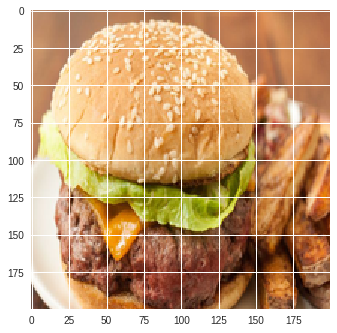

In [11]:
response = requests.get("https://raw.githubusercontent.com/maverick-faus/Files/master/2.jpg")
img = Image.open(BytesIO(response.content))
img = img.convert('RGB')
im = img.resize((200,200),Image.ANTIALIAS)
img_data=np.array(im)
print(img_data.shape)
plt.imshow(img_data)
plt.show()

In [33]:
data0=[]
data0.append(img_data)
data1=np.array(data0)
g=deep_neural_convolutional_class(batch_size = 1)#Batch de prueba
pred=check_net(g,data1,"./4B3.ckpt")

print(type(pred))
print(pred[0][0])


precio=pred[0][:,0:5]
estilo=pred[0][:,5:11]
pan=pred[0][:,11:15]
guarnicion=pred[0][:,15:19]



class_precio=list(precio[0]).index(max(precio[0]))
class_estilo=list(estilo[0]).index(max(estilo[0]))
class_pan=list(pan[0]).index(max(pan[0]))
class_guar=list(guarnicion[0]).index(max(guarnicion[0]))

print(class_precio,class_estilo,class_pan,class_guar)

Tensor("capas_conv/MaxPool:0", shape=(1, 100, 100, 32), dtype=float32)
Tensor("capas_conv/MaxPool_1:0", shape=(1, 50, 50, 64), dtype=float32)
Tensor("capas_conv/MaxPool_2:0", shape=(1, 24, 24, 128), dtype=float32)
Tensor("capas_conv/MaxPool_3:0", shape=(1, 12, 12, 256), dtype=float32)
Tensor("capas_conv/MaxPool_4:0", shape=(1, 6, 6, 512), dtype=float32)
Tensor("capas_conv/Embeding:0", shape=(1, 18432), dtype=float32)
INFO:tensorflow:Restoring parameters from ./4B3.ckpt
<class 'list'>
[-3.6548507e+13 -4.7809416e+13 -8.3429840e+13 -2.2574606e+13
 -7.6446156e+13  5.3799796e+13  8.3267009e+13  1.2393510e+13
  4.1990222e+13  3.7312784e+13  6.7189508e+13 -1.1980368e+13
  1.9985594e+13  1.0055576e+13  1.0945269e+13  6.0883169e+12
  8.2935768e+13]
3 1 1 1
